In [3]:
%cd ~/Desktop/workspace/
TTS_PATH = "~/Desktop/workspace/TTS"

/home/sam/Desktop/workspace


In [4]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import glob
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.datasets.preprocess import *
from ipywidgets import *
%matplotlib inline

In [5]:
DATA_PATH = "/home/sam/Desktop/workspace/Oscar/"
META_DATA = ["metadata.csv"]
NUM_PROC = 8

In [6]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = mailabs(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))
# print(items)

hi
/home/sam/Desktop/workspace/Oscar/metadata.csv
 | > metadata.csv
 > Number of audio files: 320


In [7]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_path)

In [8]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [9]:
from ipywidgets import *

In [10]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [11]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



 > Number of words: 515


In [12]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

In [14]:
for item in data:
    if item[-1] < 2:
        print(item)

('/home/sam/Desktop/workspace/Oscar/wavs/238.wav', '行 街 紙 得 唔 得', 11, array([-0.0090332 , -0.01089478, -0.00622559, ...,  0.00219727,
        0.00262451,  0.00231934], dtype=float32), 1.9735147392290249)
('/home/sam/Desktop/workspace/Oscar/wavs/13.wav', '申 請 概 覽', 7, array([ 0.23712158,  0.20129395,  0.19067383, ..., -0.00289917,
       -0.0027771 , -0.00228882], dtype=float32), 1.173514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/233.wav', '相 片 規 格', 7, array([-5.7067871e-03,  1.8341064e-02,  9.8571777e-03, ...,
        6.1035156e-05,  3.0517578e-05,  3.0517578e-05], dtype=float32), 1.653514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/85.wav', '用 乜 比 錢', 7, array([-1.3671875e-02, -9.9792480e-03, -1.6143799e-02, ...,
        3.3569336e-04,  3.0517578e-05,  9.1552734e-05], dtype=float32), 1.653514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/197.wav', '去 泰 國 又 得 唔 得', 13, array([0.00076294, 0.00314331, 0.00170898, ..., 0.00048828, 0.00061035,
       0.00085449], dtyp

In [15]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [16]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.18735054381971777
0.03660117391554743


In [18]:
dist = norm(mean, std)
counter = 0

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        counter+=1
        print(item)

print("number of irregular instances long or short voice durations:")
print(counter)

('/home/sam/Desktop/workspace/Oscar/wavs/310.wav', '搬 屋 要 轉 新 地 址', 13, array([ 0.00790405,  0.00891113,  0.00970459, ..., -0.00137329,
       -0.00082397, -0.00082397], dtype=float32), 3.153514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/193.wav', '澳 洲 得 唔 得', 9, array([-0.0045166 , -0.00411987, -0.00360107, ...,  0.00054932,
        0.00067139,  0.00067139], dtype=float32), 2.233514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/178.wav', '補 領 國 際 車 牌', 11, array([0.00183105, 0.00180054, 0.0015564 , ..., 0.00216675, 0.00201416,
       0.00213623], dtype=float32), 2.533514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/66.wav', '所 需 時 間', 7, array([ 0.00973511,  0.00897217,  0.00857544, ..., -0.00100708,
       -0.00027466, -0.00149536], dtype=float32), 2.733514739229025)
('/home/sam/Desktop/workspace/Oscar/wavs/95.wav', '點 比 錢', 5, array([-0.00457764, -0.00497437, -0.00402832, ...,  0.00048828,
        0.00042725,  0.00054932], dtype=float32), 2.053514739229025)
('/hom

### Plot Dataset Statistics

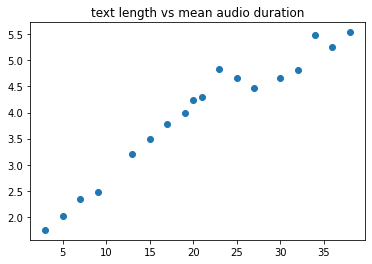

In [18]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

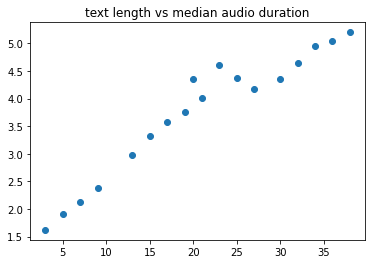

In [19]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

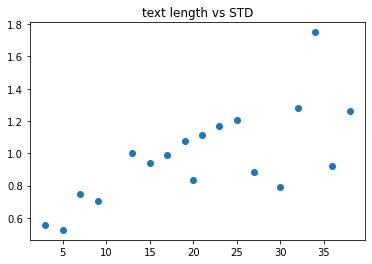

In [20]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

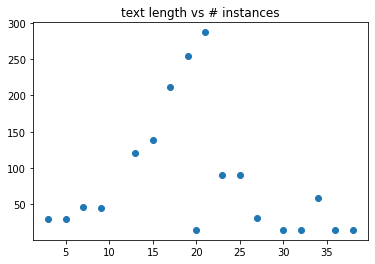

In [21]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [22]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [23]:
w_count_df

,0
一,782
個,699
四,667
係,652
三,650
...,...
記,15
j,15
兩,15
h,15


In [26]:
# check a certain word
w_count_df.at['個', 0]

699

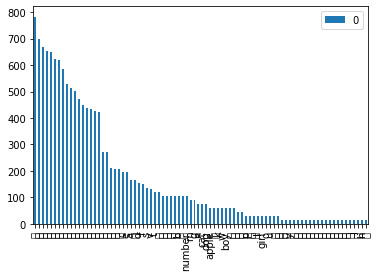

In [27]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()